In [4]:
f_func <- "./functions.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_func, '--to=script', '--stdout'), stdout = TRUE)))

f_data_loading <- "./data_loading.ipynb"
eval(parse(text = system2('jupyter', c('nbconvert', f_data_loading, '--to=script', '--stdout'), stdout = TRUE)))

In [21]:
plot_tmp <- list()
for (sel_sample in c("plasma", "BAL")){
    if(sel_sample == "plasma"){TLEN_min <- 35; TLEN_max <- 75}
    if(sel_sample == "BAL"){TLEN_min <- 35; TLEN_max <- 75}
    
    sel_samples_subsampling <- Afum_IS_meta %>% 
        filter(TLEN >= TLEN_min & TLEN <= TLEN_max) %>%
        group_by(sample_id, read, sample_type, sample, type) %>%  
        summarise(sumCount = sum(Count), .groups = 'drop') %>% 
        filter(sample == sel_sample) %>% 
        filter(sumCount >= 40)
    
    for (nr_sub in 1:nrow(sel_samples_subsampling)){
        tmp_read <- sel_samples_subsampling$read[nr_sub]
        tmp_smpl <- sel_samples_subsampling$sample_id[nr_sub] 
        
        host_nonMT_75to125bp <- host_nonMT_IS_meta %>% 
            filter(TLEN >= TLEN_min & TLEN <= TLEN_max) %>%
            mutate(EndX = substr(EndMotif, 1, 1)) %>% 
            group_by(sample_id, origin, sample_short, patient, read, sample, type, sample_type, EndX) %>%
            summarise(sumCount = sum(Count), .groups = 'drop') %>%  # Ensure to drop grouping after summarizing
            group_by(sample_id, origin, sample_short, patient, read, sample, type, sample_type) %>%
            mutate(nsCount = sumCount / sum(sumCount) * 100) %>%
            ungroup() %>%  # Ungroup to avoid unwanted grouping issues in ggplot
            filter(sample == sel_sample) %>% 
        
            filter(sample_id == tmp_smpl) %>% 
            filter(read == tmp_read) %>% 
            filter(sample_type == sel_samples_subsampling$sample_type[nr_sub]) 
        
            # Assuming host_nonMT_75to125bp is your data frame
            # Create a vector of repeated EndX values based on sumCount
            result_string <-  host_nonMT_75to125bp %>%
                select(EndX, sumCount) %>%  # Select relevant columns
                rowwise() %>%               # Operate on each row
                summarise(string_rep = rep(EndX, sumCount)) %>%  # Create string with repetitions
                pull(string_rep)          # Extract the result as a character vector

            # Initialize a list to store subsampling results
            subsampling_results <- list()

            # Perform subsampling 1000 times
            for (i in 1:10000) {
                set.seed(i)  # Set seed for reproducibility
                # Ensure that sumCount[nr_sub] is a valid number
                n_samples <- sel_samples_subsampling$sumCount[nr_sub]

                if (n_samples > 0) {
                    subsampling_results[[i]] <- sample(result_string, size = n_samples, replace = TRUE) %>% table() 
                } else {
                    warning(paste("Invalid sample size for iteration", i))
                }
            }

            # Bind subsampling results into a data frame
            final_results <- bind_rows(subsampling_results, .id = "subsampling_iteration")

            # Assuming Afum_IS_meta is your data frame and sel_samples_subsampling is properly defined
            result <- Afum_IS_meta %>%
                filter(TLEN >= TLEN_min & TLEN <= TLEN_max) %>%
                mutate(EndX = substr(EndMotif, 1, 1)) %>% 
                group_by(sample_id, read, sample_type, sample, type, EndX) %>%  
                summarise(sumCount = sum(Count), .groups = 'drop') %>% 
                filter(sample == sel_sample)  %>% 
                filter(sample_id == tmp_smpl) %>% 
                filter(read == tmp_read) %>% 
                select(EndX, sumCount) 

            plot_tmp[[tmp_smpl]][[tmp_read]] <- final_results %>% 
                melt() %>% 
                mutate(value_norm = as.numeric(value)/sel_samples_subsampling$sumCount[nr_sub]*100) %>% 
                ggplot(aes(x= variable, y = value_norm)) + 
                    geom_boxplot() + 
                    geom_point(data = result, aes(x = EndX, y = sumCount/sum(sumCount, na.rm = TRUE)*100), col = "red") + 
                    ggtitle(paste0(tmp_smpl, ", ", tmp_read)) + 
                    theme_bw() + labs(color = 'observed', 
                                      y = "Percentage of fragments (%)",
                                      x = "End-motif 1-mer")
         
    }
    Afum_IS_meta %>% 
        filter(TLEN >= TLEN_min & TLEN <= TLEN_max) %>%
        group_by(sample_id, read, sample_type, sample, type) %>%  
        summarise(sumCount = sum(Count), .groups = 'drop') %>% 
        filter(sample == sel_sample) %>% 
        filter(sumCount >= 20) %>% filter(read == "R1") %>% nrow() %>% print()
}

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
Warning message in melt(.):
“The melt generic in data.table has been passed a tbl_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”
Using subsampling_iteration as id variables

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` alwa

[1] 1


Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` always returns an ungrouped data frame and adjust
  accordingly.”
Warning message in melt(.):
“The melt generic in data.table has been passed a tbl_df and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(.). In the next version, this warning will become an error.”
Using subsampling_iteration as id variables

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()` alwa

[1] 6


Warning message:
“Removed 8 rows containing non-finite outside the scale range (`stat_boxplot()`).”
Warning message:
“Removed 3 rows containing non-finite outside the scale range (`stat_boxplot()`).”


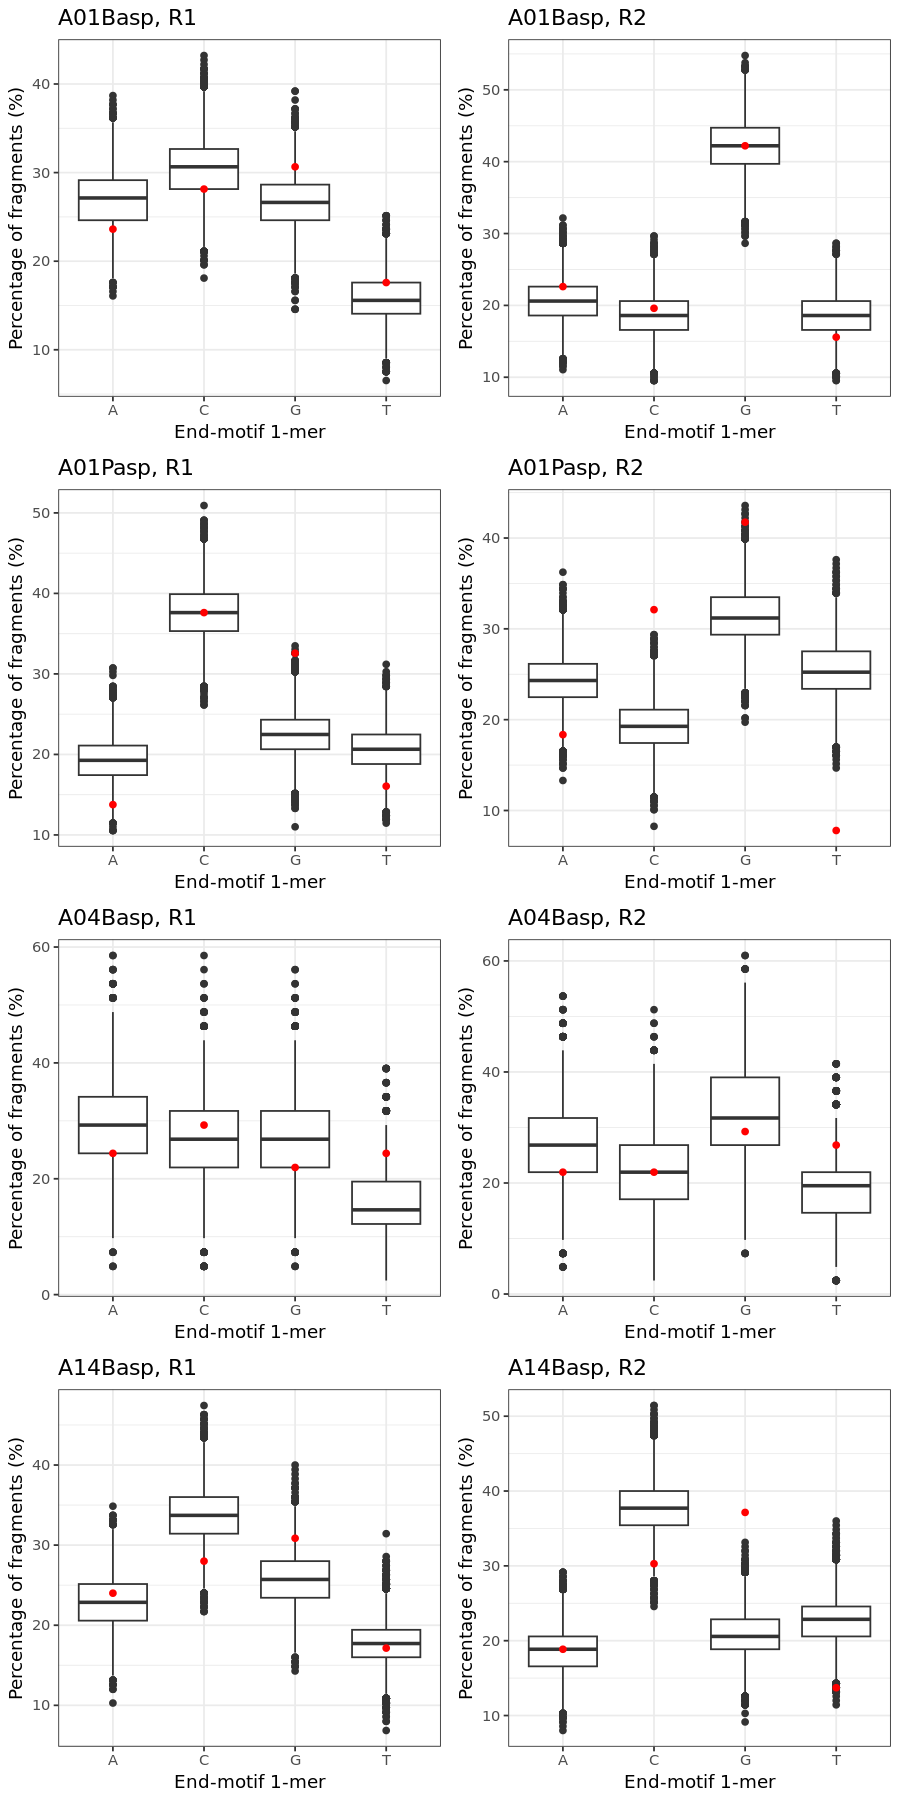

In [26]:
library("gridExtra")
options(repr.plot.width=7.5, repr.plot.height=15)
grid.arrange(ncol = 2,
    plot_tmp[[2]][[1]], plot_tmp[[2]][[2]], 
    plot_tmp[[1]][[1]], plot_tmp[[1]][[2]], 
    plot_tmp[[3]][[1]], plot_tmp[[3]][[2]], 
    plot_tmp[[4]][[1]], plot_tmp[[4]][[2]])

In [6]:
#before size size selection
Afum_IS_meta %>% 
    group_by(sample_id, read, sample_type, sample, type) %>%  
    summarise(sumCount = sum(Count), .groups = 'drop') %>% 
    filter(read == "R1") %>%   
    summarise(median_sumCount = median(sumCount), .groups = 'drop')

print("# plasma samples, prior to size selection")
Afum_IS_meta %>% 
        group_by(sample_id, read, sample_type, sample, type) %>%  
        summarise(sumCount = sum(Count), .groups = 'drop') %>% 
        filter(sample == "plasma") %>% 
        filter(sumCount >= 40) %>% filter(read == "R1") %>% nrow()

print("# BAL samples, prior to size selection")
Afum_IS_meta %>% 
        group_by(sample_id, read, sample_type, sample, type) %>%  
        summarise(sumCount = sum(Count), .groups = 'drop') %>% 
        filter(sample == "BAL") %>% 
        filter(sumCount >= 40) %>% filter(read == "R1") %>% nrow()

#after size size selection
for (sel_sample in c("plasma", "BAL")){
    print(paste0("# ", sel_sample, " samples, after size selection"))
    
    if(sel_sample == "plasma"){TLEN_min <- 35; TLEN_max <- 70}
    if(sel_sample == "BAL"){TLEN_min <- 75; TLEN_max <- 100}
    
    Afum_IS_meta %>% 
        filter(TLEN >= TLEN_min & TLEN <= TLEN_max) %>%
        group_by(sample_id, read, sample_type, sample, type) %>%  
        summarise(sumCount = sum(Count), .groups = 'drop') %>% 
        filter(sample == sel_sample) %>% 
        filter(sumCount >= 20) %>% filter(read == "R1") %>% nrow() %>% print()
}

median_sumCount
<int>
26


[1] "# plasma samples, prior to size selection"


[1] 4

[1] "# BAL samples, prior to size selection"


[1] 10

[1] "# plasma samples, after size selection"
[1] 1
[1] "# BAL samples, after size selection"
[1] 5
